<a href="https://colab.research.google.com/github/Rajdeep7102/Rajdeep7102/blob/main/Practice_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import scipy.io as io
import numpy as np
import scipy.ndimage as nd
import matplotlib.pyplot as plt
import keras 
import tensorflow as tf
import os
from keras import Input, Sequential
import glob

In [ ]:
!pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/Colab Notebooks'

In [ ]:
%cd /content/gdrive/MyDrive/

/content/gdrive/MyDrive


In [ ]:
import zipfile 
def unzip_data(filename):
  zip_ref = zipfile.ZipFile(filename,"r")
  zip_ref.extractall()
  zip_ref.close()

In [ ]:

unzip_data('/content/gdrive/MyDrive/3DShapeNetsCode.zip')

In [ ]:
voxels = io.loadmat("/content/gdrive/MyDrive/3DShapeNets/volumetric_data/airplane/30/test/1026dd1b26120799107f68a9cb8e3c_1.mat")['instance']

In [ ]:
voxels = np.pad(voxels,(1,1),'constant',constant_values=(0,0))

In [ ]:
voxels = nd.zoom(voxels,(2,2,2),mode='constant',order=0)

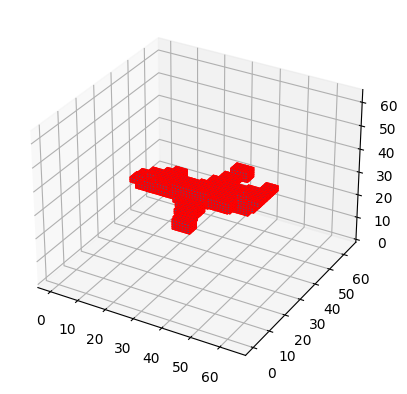

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.set_aspect('auto')
ax.voxels(voxels,edgecolor="red")
plt.show()

In [ ]:
from keras.models import Model

In [ ]:
def build_generator():
    z_size=200
    gen_filters=[512,256,128,64,1]
    gen_kernel_sizes = [4,4,4,4,4]
    gen_strides = [1,2,2,2,2]
    gen_input_shape = (1,1,1,z_size)
    gen_activations=['relu','relu','relu','relu','sigmoid']
    gen_convolutional_blocks=5

    input_layer = Input(shape=gen_input_shape)

#First 3D Transpose convolution (or 3d deconvolution) block
    a = tf.keras.layers.Conv3DTranspose(filters=gen_filters[0],
            kernel_size=gen_kernel_sizes[0],
            strides=gen_strides[0])(input_layer)
    a= tf.keras.layers.BatchNormalization()(a,training=True)
    a=tf.keras.layers.Activation(activation='relu')(a)
    
# Next 4 3D transpose convolution(or 3D deconvolution) blocks
    for i in range(gen_convolutional_blocks -1):
        a = tf.keras.layers.Conv3DTranspose(filters=gen_filters[i+1],
                                           kernel_size=gen_kernel_sizes[i+1],
                                            strides=gen_strides[i+1],padding='same')(a)
        a = tf.keras.layers.BatchNormalization()(a,training=True)
        a = tf.keras.layers.Activation(activation=gen_activations[i+1])(a)

    gen_model = Model(inputs=input_layer,outputs=a)
    
    gen_model.summary()
    return gen_model

In [ ]:
def build_discriminator():
    
    dis_input_shape = (64,64,64,1)
    dis_filters = [64,128,356,512,1]
    dis_kernel_sizes = [4,4,4,4,4]
    dis_strides = [2,2,2,2,1]
    dis_paddings = ['same','same','same','same','valid']
    dis_alphas = [0.2,0.2,0.2,0.2,0.2]
    dis_activations = ['leaky_relu','leaky_relu','leaky_relu','leaky_relu','sigmoid']
    dis_convolutional_blocks =5
    
    dis_input_layer = Input(shape=dis_input_shape)
    
    a = tf.keras.layers.Conv3DTranspose(filters=dis_filters[0],
                                       kernel_size=dis_kernel_sizes[0],
                                        strides=dis_strides[0],
                                        padding=dis_paddings[0])(dis_input_layer)
    a = tf.keras.layers.BatchNormalization()(a,training=True)
    a = tf.keras.layers.LeakyReLU(dis_alphas[0])(a)
    
    for i in range(dis_convolutional_blocks -1):
        a = tf.keras.layers.Conv3DTranspose(filters=dis_filters[i+1],
                                           kernel_size=dis_kernel_sizes[i+1],
                                           strides=dis_strides[i+1],
                                           padding=dis_paddings[i+1])(a)
        a = tf.keras.layers.BatchNormalization()(a,training=True)
        if dis_activations[i+1] == 'leaky_relu':
            a = tf.keras.layers.LeakyReLU(dis_alphas[i+1])(a)
        elif dis_activations[i+1] == 'sigmoid':
            a = tf.keras.layers.Activation(activation='sigmoid')(a)
            
        dis_model = tf.keras.Model(inputs=dis_input_layer,outputs=a)
        print(dis_model.summary())
    return dis_model

In [ ]:
gen_learning_rate = 0.0025
dis_learning_rate = 0.00001
beta = 0.5
batch_size = 200
generated_volumes_dir = 'generated_volumes'
log_dir = 'logs'

In [ ]:
# Create instances
generator = build_generator()
discriminator  = build_discriminator()

# Specify optimizer
gen_optimizer = tf.keras.optimizers.Adam(lr=gen_learning_rate,beta_1=beta)
dis_optimizer = tf.keras.optimizers.Adam(lr=dis_learning_rate,beta_1=0.9)

# Compile networks
generator.compile(loss="binary_crossentropy",optimizer="adam")
discriminator.compile(loss='binary_crossentropy',optimizer=dis_optimizer)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 1, 1, 200)]    0         
                                                                 
 conv3d_transpose (Conv3DTra  (None, 4, 4, 4, 512)     6554112   
 nspose)                                                         
                                                                 
 batch_normalization (BatchN  (None, 4, 4, 4, 512)     2048      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 4, 4, 4, 512)      0         
                                                                 
 conv3d_transpose_1 (Conv3DT  (None, 8, 8, 8, 256)     8388864   
 ranspose)                                                       
                                                             

None


In [ ]:
# Create and compile the adversarial model

discriminator.trainable = False
adversarial_model = Sequential()
adversarial_model.add(generator)
adversarial_model.add(discriminator)
adversarial_model.compile(loss="binary_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=gen_learning_rate))

In [ ]:
DIR_PATH = '/content/gdrive/MyDrive/3DShapeNets/volumetric_data/'

In [ ]:
#load all airplane image for training

def getVoxelsFromMat(path, cube_len=64):
    voxels = np.pad(io.loadmat(path)['instance'], (1, 1), 'constant', constant_values=0)
    if cube_len != 32 and cube_len == 64:
        voxels = nd.zoom(voxels, (2, 2, 2), mode='constant', order=0)
    return voxels.astype(np.float32)[..., np.newaxis]

def get3ImagesForACategory(obj='airplane', train=True, cube_len=64, obj_ratio=1.0):
    obj_path = DIR_PATH + obj + '/30/'
    print(obj_path)
    obj_path1 = 'train/' if train else 'test/'
    obj_path = obj_path + obj_path1
    print(obj_path)
    fileList = [f for f in os.listdir(obj_path) if f.endswith('.mat')]
    fileList = fileList[:int(obj_ratio * len(fileList))]
    volumeBatch = np.stack([getVoxelsFromMat(os.path.join(obj_path, f), cube_len) for f in fileList])
    return volumeBatch

volumes = get3ImagesForACategory(obj='airplane', train=True, obj_ratio=1.0)
volumes = volumes[..., np.newaxis].astype(np.float)

NameError: ignored

In [ ]:
for epoch in range(epochs):
    print("Epoch:", epoch)
# Create two lists to store losses
    gen_losses = []
    dis_losses = []
    number_of_batches = int(volumes.shape[0] / batch_size)
    print("Number of batches:", number_of_batches)
    for index in range(number_of_batches):
        print("Batch:", index + 1)
  

NameError: ignored